In [ ]:
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
spacex_df_old = pd.read_csv("spacex_launch_dash.csv")
#max_payload = spacex_df['Payload Mass (kg)'].max()
#min_payload = spacex_df['Payload Mass (kg)'].min()

spacex_df = pd.read_csv("spaceX_data2.csv",parse_dates=True)
max_payload = spacex_df['PayloadMass'].max()
min_payload = spacex_df['PayloadMass'].min()
max_year = spacex_df['Year'].max()
min_year = spacex_df['Year'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                html.Div([html.Label("Select Launch Site: "),
                                        dcc.Dropdown(id='site-dropdown',
                                                    options=[{'label':'All Sites','value':'ALL'}]+
                                                    [{'label':i,'value':i} for i in spacex_df['LaunchSite'].unique()],
                                                    value='ALL',
                                                    placeholder='launch site dropdown',
                                                    searchable=True)]
                                        ),
                                html.Br(),
                                
                                html.P("Date range:"),
                                html.Div(dcc.RangeSlider(id='date-slider',min=2010, max=2020, step=1,value=[2010,2020],marks={i: '{}'.format(i) for i in range(2010,2021,1)})),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div([dcc.Graph(id='success-sunburst-chart',style={'width': '25vw'}),
                                          dcc.Graph(id='success-pie-chart',style={'width': '25vw'}),
                                          dcc.Graph(id='success-bar-chart',style={'width': '25vw'}),
                                          dcc.Graph(id='success-boost-chart',style={'width': '25vw'})]
                                         , style={'display': 'flex'}),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                #dcc.RangeSlider(id='payload-slider',...)
                                html.Div(dcc.RangeSlider(id='payload-slider',min=0, max=16000, step=1000,value=[min_payload, max_payload])),
                                
                                

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div([dcc.Graph(id='success-payload-scatter-chart',style={'width': '50vw'}),
                                          dcc.Graph(id='success-payload-hist-chart',style={'width': '50vw'})]
                                        , style={'display': 'flex'}),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback([Output(component_id='success-sunburst-chart',component_property='figure'),
              Output(component_id='success-pie-chart',component_property='figure'),
              Output(component_id='success-bar-chart',component_property='figure'),
              Output(component_id='success-boost-chart',component_property='figure')],
            [Input(component_id='site-dropdown',component_property='value'),
            Input(component_id='payload-slider',component_property='value'),
             Input(component_id='date-slider',component_property='value')
            ]
             )
def get_pie_chart(entered_site,slider_values,year):
    
    if entered_site == 'ALL':
        
        filtered_df=(spacex_df[(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])].groupby(by=['LaunchSite','Class']).count()).FlightNumber.to_frame().reset_index()
        filtered_df.sort_values(by='LaunchSite',inplace=True)
        filtered_df.reset_index(inplace=True)
        filtered_df.rename(columns={'FlightNumber':'Outcome'},inplace=True)
        total_number=filtered_df.Outcome.sum()
        filtered_df['pct']=round(100*filtered_df['Outcome']/total_number,2)
        
        for ls in list(filtered_df.LaunchSite.unique()):
            filtered_df_gp=filtered_df.groupby(by='LaunchSite')['Outcome'].sum()
            filtered_df.loc[filtered_df['LaunchSite']==ls,'LaunchSite_pct']=filtered_df.loc[filtered_df['LaunchSite']==ls,'Outcome']/filtered_df_gp[ls]

        fig_sun=px.sunburst(filtered_df,values='pct',path=['LaunchSite','Class','Outcome'],title='Outcome breakdown by Launch Site between {:4} and {:4}'.format(year[0],year[1]))
        
        filtered_pie_df=spacex_df[(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])].groupby(by='LaunchSite')['Class'].sum().to_frame()
        filtered_pie_df.reset_index(inplace=True)

        fig_pie=px.pie(filtered_pie_df,values='Class',names='LaunchSite',title='Proportion of Successful Launches attributable to each Site')
        fig_bar=px.bar(filtered_df[filtered_df['Class']==1],y='LaunchSite_pct',x='LaunchSite',title='Proportion of Successful Launches in each Site',range_y=[0,1])
        fig_bar.update_yaxes(tick0=0, dtick=0.1)
        fig_bar.update_xaxes(categoryorder='total ascending')
        
        filtered_boost_df=spacex_df[(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])].groupby(by='BoosterCategory')['Class'].mean().to_frame()
        filtered_boost_df.reset_index(inplace=True)
        filtered_boost_df.sort_values(by='Class',inplace=True)
        fig_bar_boost=px.bar(filtered_boost_df,y='Class',x='BoosterCategory',title='Booster category success rate for all sites',range_y=[0,1])
        fig_bar_boost.update_yaxes(tick0=0, dtick=0.1)
        fig_bar_boost.update_xaxes(categoryorder='total ascending')


        return [fig_sun,fig_pie,fig_bar,fig_bar_boost]
    else:
        
        filtered_df=(spacex_df[(spacex_df['LaunchSite']==entered_site)&(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])].groupby(by=['LaunchSite','Class']).count()).FlightNumber.to_frame().reset_index()
        filtered_df.sort_values(by='LaunchSite',inplace=True)
        filtered_df.reset_index(inplace=True)
        filtered_df.rename(columns={'FlightNumber':'Outcome'},inplace=True)
        total_number=filtered_df.Outcome.sum()
        filtered_df['pct']=round(100*filtered_df['Outcome']/total_number,2)
        
        for ls in list(filtered_df.LaunchSite.unique()):
            filtered_df_gp=filtered_df.groupby(by='LaunchSite')['Outcome'].sum()
            filtered_df.loc[filtered_df['LaunchSite']==ls,'LaunchSite_pct']=filtered_df.loc[filtered_df['LaunchSite']==ls,'Outcome']/filtered_df_gp[ls]

        fig_sun=px.sunburst(filtered_df,values='pct',path=['LaunchSite','Class','Outcome'],title='Outcome breakdown at {:} between {:4} and {:4}'.format(entered_site,year[0],year[1]))
        
        filtered_pie_df=spacex_df[(spacex_df['LaunchSite']==entered_site)&(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])].groupby(by='Class')['LaunchSite'].count().to_frame()
        filtered_pie_df.reset_index(inplace=True)
        
        fig_pie=px.pie(filtered_pie_df,values='LaunchSite',names='Class',title='Percentage of Successful Launches for Site: '+ entered_site)
        fig_bar=px.bar(filtered_df[filtered_df['Class']==1],y='LaunchSite_pct',x='LaunchSite',title='Proportion of Successful Launches for Site: '+entered_site,range_y=[0,1])
        fig_bar.update_yaxes(tick0=0, dtick=0.1)
        fig_bar.update_xaxes(categoryorder='total ascending')
        
        filtered_boost_df=spacex_df[(spacex_df['LaunchSite']==entered_site)&(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])].groupby(by='BoosterCategory')['Class'].mean().to_frame()
        filtered_boost_df.reset_index(inplace=True)
        filtered_boost_df.sort_values(by='Class',inplace=True)
        fig_bar_boost=px.bar(filtered_boost_df,y='Class',x='BoosterCategory',title='Booster category success rate for Site: '+entered_site,range_y=[0,1])
        fig_bar_boost.update_yaxes(tick0=0, dtick=0.1)
        fig_bar_boost.update_xaxes(categoryorder='total ascending')

        return [fig_sun,fig_pie,fig_bar,fig_bar_boost]
    
# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback([Output(component_id='success-payload-scatter-chart',component_property='figure'),
              Output(component_id='success-payload-hist-chart',component_property='figure')],
            [Input(component_id='site-dropdown',component_property='value'),
            Input(component_id='payload-slider',component_property='value'),
             Input(component_id='date-slider',component_property='value')
            ])
def get_scatter_chart(entered_site,slider_values,year):
    if entered_site == 'ALL':
        filtered_df=spacex_df[(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])]
        fig_scat=px.scatter(filtered_df,y='Class',x='PayloadMass',color="BoosterCategory",title='Scatter of successes and failures for different payloads colored by booster category for all launch sites')
        fig_scat.update_xaxes(tick0=0, dtick=1000)
        fig_hist=px.histogram(filtered_df,x='PayloadMass',color="BoosterCategory",facet_row='Class',opacity=0.5,nbins=16,title='Histogram of successes and failures for different payloads for all launch sites')
        fig_hist.update_xaxes(tick0=0, dtick=1000)

        return [fig_scat,fig_hist]
    else:
        filtered_df=spacex_df[(spacex_df['LaunchSite']==entered_site)&(spacex_df['PayloadMass']>=slider_values[0])&(spacex_df['PayloadMass']<=slider_values[1])&(spacex_df['Year']>=year[0])&(spacex_df['Year']<=year[1])]
        fig_scat=px.scatter(filtered_df,y='Class',x='PayloadMass',color="BoosterCategory",range_x=[0,16000],range_y=[-0.5,1.5],title='Scatter of successes and failures for different payloads colored by booster category for the launch site: '+ entered_site)
        fig_scat.update_xaxes(tick0=0, dtick=1000)
        fig_hist=px.histogram(filtered_df,x='PayloadMass',color="BoosterCategory",facet_row='Class',opacity=0.5,nbins=16,title='Histogram of successes and failures for different payloads for the launch site: '+ entered_site)
        fig_hist.update_xaxes(tick0=0, dtick=1000)
        return [fig_scat,fig_hist]

# Run the app
if __name__ == '__main__':
    app.run_server()


Dash is running on http://127.0.0.1:8050/



C:\Users\Vishal\AppData\Local\Temp\ipykernel_27408\3280762458.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\Vishal\AppData\Local\Temp\ipykernel_27408\3280762458.py:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [13/Mar/2024 20:34:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2024 20:34:56] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2024 20:34:56] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2024 20:34:56] "GET /_favicon.ico?v=2.7.0 HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2024 20:34:56] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [13/Mar/2024 20:34:56] "GET /_dash-component-suites/dash/dcc/async-slider.js HTTP/1.1" 304 -
127.0.0.1 - - [13/Mar/2024 20:34:56] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [13/Mar/2024 20:34:56] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [13/Mar/2024 20:34:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2024 20:34:57] "POST /_dash-update-component HTTP/1.1" 200 -


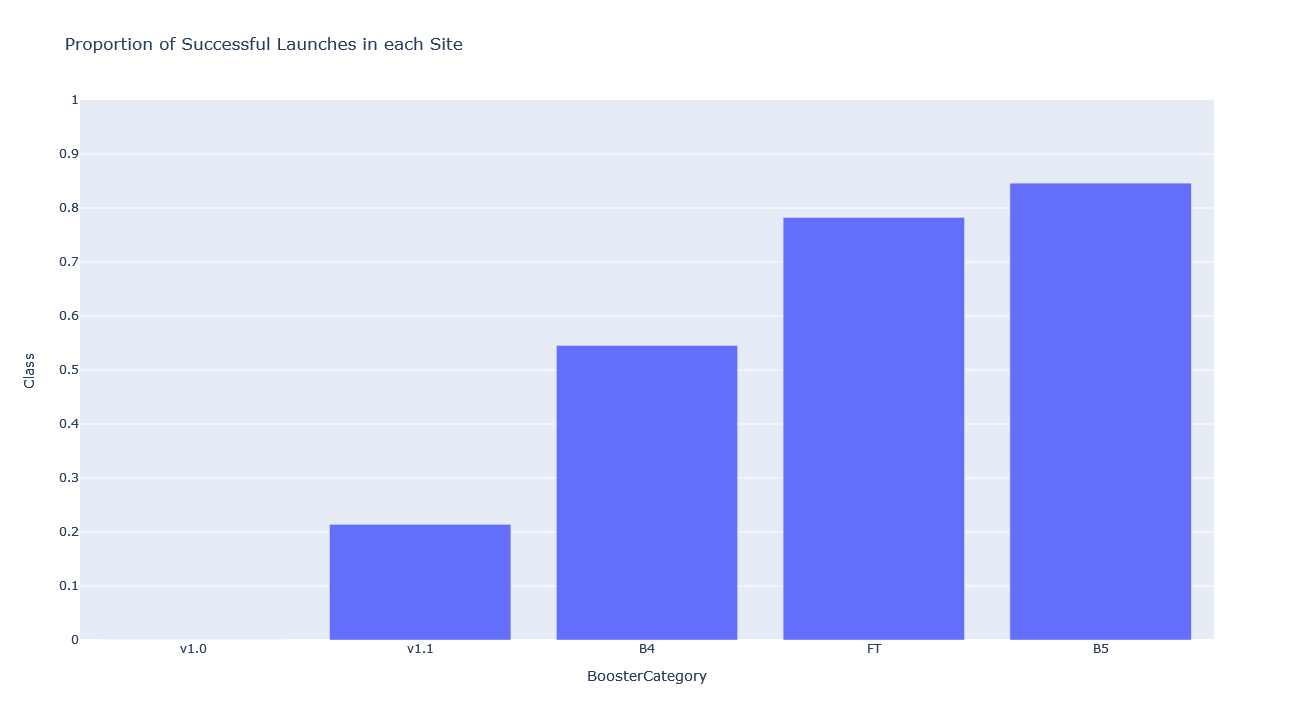

In [11]:
filtered_boost_df=spacex_df[(spacex_df['PayloadMass']>=0)&(spacex_df['PayloadMass']<=16000)&(spacex_df['Year']>=2010)&(spacex_df['Year']<=2020)].groupby(by='BoosterCategory')['Class'].mean().to_frame()
filtered_boost_df.reset_index(inplace=True)
filtered_boost_df.sort_values(by='Class',inplace=True)
fig_bar_boost=px.bar(filtered_boost_df,y='Class',x='BoosterCategory',title='Proportion of Successful Launches in each Site',range_y=[0,1])
fig_bar_boost.update_yaxes(tick0=0, dtick=0.1)

In [12]:
filtered_boost_df

,BoosterCategory,Class
3,v1.0,0.000000
4,v1.1,0.214286
0,B4,0.545455
2,FT,0.782609
1,B5,0.846154


Finding Insights Visually

Now with the dashboard completed, you should be able to use it to analyze SpaceX launch data, and answer the following questions:

    Which site has the largest successful launches?
    Which site has the highest launch success rate?
    Which payload range(s) has the highest launch success rate?
    Which payload range(s) has the lowest launch success rate?
    Which F9 Booster version (v1.0, v1.1, FT, B4, B5, etc.) has the highest
    launch success rate?

In [12]:
q=(spacex_df_old.groupby(by=['Booster Version Category','class']).count())['Flight Number'].to_frame().reset_index().rename(columns={'Flight Number':'Outcome'})
#q=(spacex_df[(spacex_df['LaunchSite']=='CCAFS SLC 40')&(spacex_df['Year']>=2017)&(spacex_df['Year']<=2020)].groupby(by=['LaunchSite','Class']).count()).FlightNumber.to_frame().reset_index().rename(columns={'FlightNumber':'Outcome'})
q

,Booster Version Category,class,Outcome
0,B4,0,5
1,B4,1,6
2,B5,1,1
3,FT,0,8
4,FT,1,16
5,v1.0,0,5
6,v1.1,0,14
7,v1.1,1,1


In [13]:
for ls in list(q['Booster Version Category'].unique()):
    qq=q.groupby(by='Booster Version Category')['Outcome'].sum()
    #print(ls,qq[ls])
    q.loc[q['Booster Version Category']==ls,'Serial_pct']=q.loc[q['Booster Version Category']==ls,'Outcome']/qq[ls]
q.sort_values(by='Booster Version Category')

,Booster Version Category,class,Outcome,Serial_pct
0,B4,0,5,0.454545
1,B4,1,6,0.545455
2,B5,1,1,1.000000
3,FT,0,8,0.333333
4,FT,1,16,0.666667
5,v1.0,0,5,1.000000
6,v1.1,0,14,0.933333
7,v1.1,1,1,0.066667


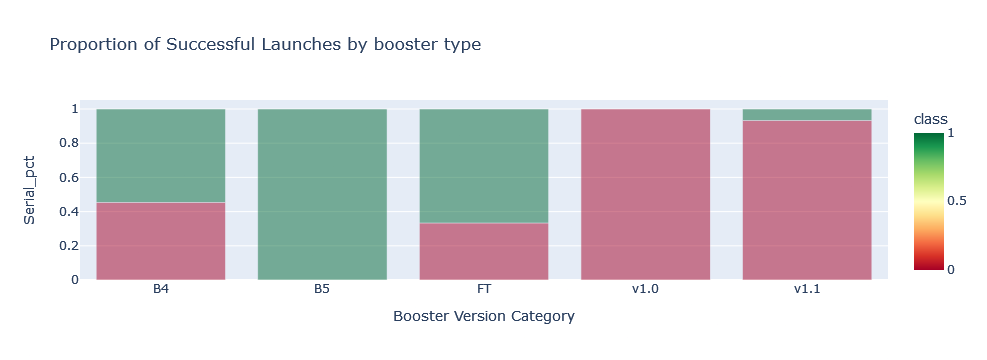

In [15]:
px.bar(q,color='class',opacity=0.5,y='Serial_pct',x='Booster Version Category',title='Proportion of Successful Launches by booster category',color_continuous_scale='rdylgn')

In [13]:
q.loc[q['LaunchSite']==ls,'Outcome'].values

array([5], dtype=int64)

In [3]:
q.Outcome.sum()

1

In [ ]:
pd.rename()

In [ ]:
spacex_df